## Семинар 3 "Определение ключевых точек лица"

Валиахметов Булат Ильдарович

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  22 марта 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [81]:
!pip install tensorboardX
!pip install pytorch-ignite

In [99]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
from torch import nn
# Ignore warnings
import warnings


try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

In [83]:
import zipfile
import os

from google.colab import drive
from PIL import Image

In [84]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
zip_train = '/content/drive/MyDrive/sphere_nn/train.zip'
zip_test = '/content/drive/MyDrive/sphere_nn/test.zip'

z_train = zipfile.ZipFile(zip_train, 'r')
z_test = zipfile.ZipFile(zip_test, 'r')
z_test.extractall('dataset')
z_train.extractall('dataset')

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


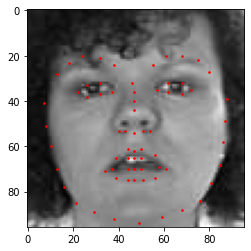

In [86]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.values[n, 1:].astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [87]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [88]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample

In [89]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [90]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())

In [91]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [92]:
class Net(Module):
    def __init__(self, activation=Sigmoid(), latent_size=200):
        super().__init__()
        self.fc1 = Linear(96 * 96, 200)
        self.fc2 = Linear(200, 68 * 2)
        self.activation = activation
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x.view(x.shape[0], -1)))).view(x.shape[0], 68, 2)

In [93]:
def run_trainer(network, device="cpu", criterion=MSELoss(),
                optim=torch.optim.Adam, learning_rate=0.01, max_epochs=10,
                writer=SummaryWriter(filename_suffix='first', logdir="logs")):

    #if torch.cuda.is_available():
    #    device = "cuda"
    print("device: {}".format(device))
    train_dataloader, test_dataloader = get_data_loaders()
    optimizer = optim(network.parameters(), lr=learning_rate)
    trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(network, device=device, 
                metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())})

    training_history = {'l1':[],'l2':[]}
    validation_history = {'l1':[],'l2':[]}
    last_epoch = []

    @trainer.on(Events.ITERATION_COMPLETED(every=10))
    def log_training_loss(engine):
        writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
        writer.flush()

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_dataloader)
        metrics = evaluator.state.metrics
        l2_train = metrics["L2 loss"]
        l1_train = metrics['L1 loss']
        last_epoch.append(0)
        training_history['l2'].append(l2_train)
        training_history['l1'].append(l1_train)
        writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
        
        evaluator.run(test_dataloader)
        metrics = evaluator.state.metrics
        l2 = metrics["L2 loss"]
        l1 = metrics['L1 loss']
        validation_history['l2'].append(l2)
        validation_history['l1'].append(l1)
        
        writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
        writer.flush()
        
        sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
            .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
    
    trainer.run(train_dataloader, max_epochs=max_epochs)
    return training_history, validation_history, last_epoch

In [59]:
training_history, validation_history, last_epoch = run_trainer(Net())

device: cpu
Training/Validation Results - Epoch: 10  Avg MSE: 17.53 / 18.56 Avg MAE: 2.98 / 3.05

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [94]:
_, test_dataloader = get_data_loaders(val_batch_size=4)

images_batch = next(iter(test_dataloader))
x, y = images_batch
#y_pred = network(x)
#y_pred = y_pred.data.numpy()
#show_landmarks_batch(images_batch, y_pred)
images_batch[0].shape

torch.Size([4, 96, 96])

In [216]:
class Landmarker(nn.Module):
    def __init__(self, image_size=96, channels=1):
        super().__init__()
        self.layers = [
                       nn.Flatten(),
                       nn.Unflatten(1, (channels, image_size, image_size)),
                       
                       nn.Conv2d(channels, 4, 3, padding=1), nn.ELU(),
                       nn.MaxPool2d(2),
                       
                       nn.Conv2d(4, 16, 3, padding=1), nn.ELU(),
                       nn.Conv2d(16, 16, 3, padding=1), nn.ELU(),
                       nn.MaxPool2d(2),

                       nn.Conv2d(16, 64, 3, padding=1), nn.ELU(),
                       nn.MaxPool2d(2),

                       nn.Conv2d(64, 256, 3, padding=1), nn.ELU(),
                       nn.MaxPool2d(4), # 256x3x3
        ]
        self.nonlin = nn.Sequential(*self.layers)
        self.lin = nn.Sequential(
            nn.Linear(256 * image_size//32 * image_size//32, 68 * 16),
            nn.BatchNorm1d(68 * 16),
            nn.ELU(), nn.Linear(68 * 16, 68 * 2))

    def forward(self, x):
        x = self.nonlin(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x.view(x.shape[0], 68, 2)

In [230]:
class Landmarker2(nn.Module):
    def __init__(self, image_size=96, channels=1):
        super().__init__()
        self.layers = [
                       nn.Flatten(),
                       nn.Unflatten(1, (channels, image_size, image_size)),
                       
                       nn.Conv2d(channels, 8, (4,4), padding=(2,2)), 
                                         nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (4,4), padding=(2,2)), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                        nn.Conv2d(16, 32, (4,4), padding=(2,2)),nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(32, 64, (4,4), padding=1),nn.ReLU(),
                                        nn.MaxPool2d(2)
        ]
        self.nonlin = nn.Sequential(*self.layers)
        self.linear_layers = nn.Sequential(nn.Linear(40*40, 400),
                                           nn.BatchNorm1d(400),
                                           nn.ReLU(),nn.Linear(400, 200),nn.ReLU(),
                                           nn.BatchNorm1d(200),
                                          nn.Linear(200, 2*68))
        # self.lin = nn.Sequential(
        #     nn.Linear(256 * image_size//32 * image_size//32, 68 * 16),
        #     nn.BatchNorm1d(68 * 16),
        #     nn.ELU(), nn.Linear(68 * 16, 68 * 2))

    def forward(self, x):
        x = self.nonlin(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x.view(x.shape[0], 68, 2)

In [217]:
network = Landmarker()
print(network)

Landmarker(
  (nonlin): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Unflatten(dim=1, unflattened_size=(1, 96, 96))
    (2): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ELU(alpha=1.0)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ELU(alpha=1.0)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ELU(alpha=1.0)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ELU(alpha=1.0)
    (15): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (lin): Sequential(
    (0

In [231]:
training_history, validation_history, last_epoch = run_trainer(Landmarker2())

device: cpu
Training/Validation Results - Epoch: 10  Avg MSE: 5.92 / 7.76 Avg MAE: 1.77 / 1.95

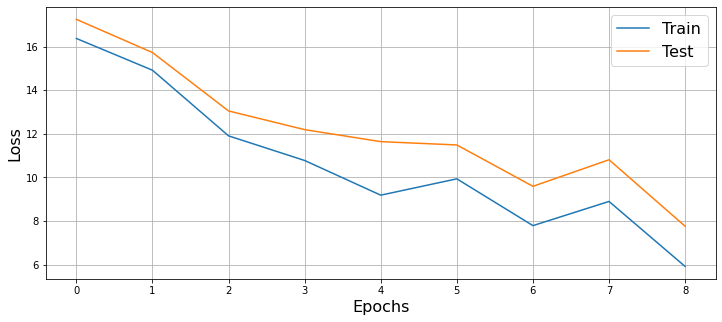

In [232]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()